In [1]:
from pynq.overlays.base import BaseOverlay
import time

from datetime import datetime
base = BaseOverlay("base.bit")
btns = base.btns_gpio

In [2]:
%%microblaze base.PMODB

#include "gpio.h"

// write function, sed by the Python PWM loop
int write_gpio(unsigned int pin, unsigned int val){
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);
    return 0;
}

//reset all pins on the PMOD to 0V (Off)
int reset_all_pins() {
    for(int i = 0; i < 8; i++) {
        gpio p = gpio_open(i);
        gpio_set_direction(p, GPIO_OUT);
        gpio_write(p, 0);
    }
    return 0;
}

In [3]:

def run_pwm(pin_num, frequency, duty_cycle, duration):
    # corner cases 0% and 100%
    if duty_cycle <= 0:
        write_gpio(pin_num, 0)
        time.sleep(duration)
        return
    if duty_cycle >= 100:
        write_gpio(pin_num, 1)
        time.sleep(duration)
        return
        
    period = 1.0 / frequency
    on_time = period * (duty_cycle / 100.0)
    off_time = period - on_time
    
    start_time = time.time()
    while (time.time() - start_time) < duration:
        write_gpio(pin_num, 1)
        time.sleep(on_time)
        write_gpio(pin_num, 0)
        time.sleep(off_time)
        
    # mapping
BLUE = 1
GREEN = 2
RED = 3 
GND = 4

Testing 0% Duty Cycle...
Testing 10% Duty Cycle...
Testing 25% Duty Cycle...
Testing 50% Duty Cycle...
Testing 75% Duty Cycle...
Testing 90% Duty Cycle...
Testing 100% Duty Cycle...


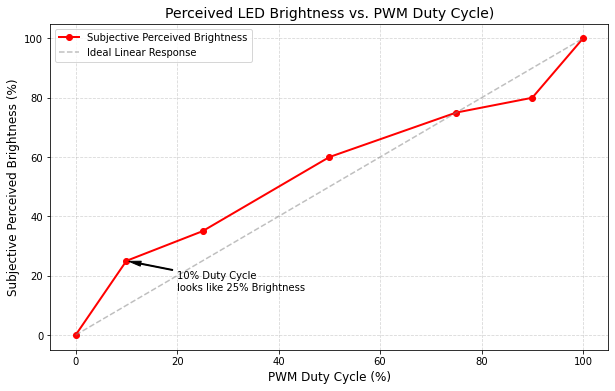

In [4]:
# find flicker-fusion threshold
#30Hz (will flicker), 60Hz (better), 100Hz (smooth)

optimal_freq = 40
test_cycles = [0, 10, 25, 50, 75, 90, 100]

for dc in test_cycles:
        print(f"Testing {dc}% Duty Cycle...")
        run_pwm(GREEN, optimal_freq, dc, 3)
        
        write_gpio(GREEN, 0) 
        time.sleep(1)
         #first go
        #10 looked 1/4 to me
        #50 looked half to me
        #100 was definitely the brightest
        
import matplotlib.pyplot as plt
        
duty_cycles = [0, 10, 25, 50, 75, 90, 100]
perceived_brightness = [0, 25, 35, 60, 75, 80, 100] #my full observations

plt.figure(figsize=(10, 6))

plt.plot(duty_cycles, perceived_brightness, 'ro-', linewidth=2, label='Subjective Perceived Brightness')
plt.plot([0, 100], [0, 100], color='gray', linestyle='--', alpha=0.5, label='Ideal Linear Response')

plt.title('Perceived LED Brightness vs. PWM Duty Cycle)', fontsize=14)
plt.xlabel('PWM Duty Cycle (%)', fontsize=12)
plt.ylabel('Subjective Perceived Brightness (%)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

plt.annotate('10% Duty Cycle\nlooks like 25% Brightness', xy=(10, 25), xytext=(20, 15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.show()

In [5]:
import asyncio

freq = 10      # my optimal
dim_dc = 25    # weak/dim duty cycle for the 25% brightness task
BLUE = 1
GREEN = 2
RED = 3 
cond = True

current_color = RED

reset_all_pins()

async def flash_leds():
    global cond, current_color
    print("Blinking Started. BTN0:R, BTN1:G, BTN2:B, BTN3:Exit")
    while cond:
        
        # 1 Second ON
        write_gpio(current_color, 1)
        await asyncio.sleep(1)
        
        # 1 Second OFF
        reset_all_pins()
        await asyncio.sleep(1)
 
async def get_btns(_loop):
    global cond, current_color
    while cond:
        await asyncio.sleep(0.01)
        if btns[0].read():  #click blue
            current_color = BLUE
        if btns[1].read():  #click green
            current_color = GREEN
        if btns[2].read():  #click red
            current_color = RED
        if btns[3].read():  #click to stop
            print("stopping")
            _loop.stop()
            cond = False
      
        
loop = asyncio.new_event_loop()
loop.create_task(flash_leds())
loop.create_task(get_btns(loop))
loop.run_forever()
loop.close() 

reset_all_pins()
print("Done.")

Blinking Started. BTN0:R, BTN1:G, BTN2:B, BTN3:Exit
stopping
Done.
